In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import seaborn as sns

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# ML algorithms
from xgboost import XGBClassifier


In [2]:
df_21600 = pd.read_csv("../final_datasets/periodicity_features/design.periodicity_features.1800.0.1.0.9.csv")

In [3]:
display(df_21600)

,id_dependency,label,packet_value,packet_value_x,packet_value_y,packet_mean,packet_std,packet_skewness,packet_kurtosis,bytes_value,...,spectral_entropy,spectral_kurtosis,spectral_skewness,spectral_rolloff,spectral_cetroid,spectral_spread,spectral_slope,spectral_crest,spectral_flux,spectral_bandwidth
0,172.65.207.106(4444)-147.32.228.51,Miner,0,476,465,473.189711,49.190613,883.900691,6821.117791,0,...,165.216241,47876.005514,10453.993283,0.000015,0.004340,0.075073,-0.211509,11.326452,5.290232,-0.005037
1,172.65.207.106(5555)-195.113.72.125,Miner,0,378,411,393.333333,29.626065,8.815476,66.395359,0,...,85.486189,836.675220,92.487524,0.000809,0.000480,0.177813,-0.121023,2.533937,8.952302,-0.000157
2,172.65.207.106(4444)-195.113.80.194,Miner,0,469,479,468.134731,84.000337,-1105.283851,5968.391855,0,...,154.300067,68852.463948,13888.902185,0.006658,0.004848,0.100462,-0.094181,16.883220,9.138817,0.005132
3,172.65.207.106(5555)-195.113.165.76,Miner,0,463,452,423.644928,109.420595,-316.144166,1212.377793,0,...,124.025024,264472.500169,18934.978952,0.003327,0.002209,0.824410,-0.029150,48.094823,11.686281,0.000235
4,172.65.207.106(4444)-195.113.149.67,Miner,0,614,612,588.025157,93.960379,412.477110,3156.225832,0,...,NaN,158124.816473,16347.282116,0.000008,0.002273,0.342323,NaN,24.422249,8.415206,-0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22040,93.234.198.199___5(9033)-147.32.30.55,Other,0,224,220,249.515152,75.786631,170.002444,904.870189,0,...,110.739568,4856.118081,1363.246145,0.000060,0.001145,0.161922,-0.130272,5.361925,8.406399,0.001549
22041,147.32.30.55(9033)-38.133.164.92___27,Other,0,239,220,230.186667,56.093658,41.128259,199.676505,0,...,112.119529,19472.855148,3310.594429,0.000066,0.001001,0.286776,-0.212824,10.788067,7.885624,-0.000662
22042,209.145.58.186___20(9033)-147.32.30.55,Other,0,288,414,344.777778,99.585402,50.750200,307.522118,0,...,114.221434,4117.812724,1081.601084,0.000066,0.000993,0.182378,-0.002969,5.534807,9.624762,0.000017
22043,147.32.30.55(9033)-207.180.249.244___6,Other,0,154,198,195.785714,45.250907,21.821135,121.879461,0,...,94.076915,9337.012923,1656.541451,0.001093,0.000769,0.443099,0.062821,9.276580,9.559618,0.000499


In [4]:
periodic_features = [
    "packet_value",
    "packet_value_x",
    "packet_value_y",
    "bytes_value",
    "bytes_value_x",
    "bytes_value_y",
    "duration_value",
    "duration_value_x",
    "duration_value_y",
    "difftimes_value",
    "difftimes_value_x",
    "difftimes_value_y",
]

statistics_features = [
    "packet_mean",
    "packet_std",
    "packet_skewness",
    "packet_kurtosis",
    "bytes_mean",
    "bytes_std",
    "bytes_skewness",
    "bytes_kurtosis",
    "duration_mean",
    "duration_std",
    "duration_skewness",
    "duration_kurtosis",
    "difftimes_mean",
    "difftimes_std",
    "difftimes_skewness",
    "difftimes_kurtosis",
]

frequency_features = [
    "max_power",
    "max_frequency",
    "min_power",
    "min_frequency",
    "spectral_energy",
    "spectral_entropy",
    "spectral_kurtosis",
    "spectral_skewness",
    "spectral_rolloff",
    "spectral_cetroid",
    "spectral_spread",
    "spectral_slope",
    "spectral_crest",
    "spectral_flux",
    "spectral_bandwidth",
]

features = periodic_features + statistics_features + frequency_features

In [5]:
len(features)

43

In [6]:
import sklearn
pd.set_option('display.max_columns', None)


def handle_nan(df, label=None):
    if label is None:
        df.loc[df.label == "Other", "label"] = False
        df.loc[df.label == "Miner", "label"] = True
        df['label'] = df.label.astype(bool)
    else:
        df['label'] = label
        df['label'] = df.label.astype(bool)
    df.replace([np.inf], -1, inplace=True)
    df.replace([-np.inf], -1, inplace=True)
    for F in features:
        if F in frequency_features: 
            df.loc[df[F].isnull(), F] = -1
        else:
            df.loc[df[F].isnull(), F] = 0
    return df


In [7]:
df_21600 = handle_nan(df_21600)

In [8]:
print(f"21600 -- cryptomining: {len(df_21600[df_21600['label'] == True])}\tclear: {len(df_21600[df_21600['label'] == False])}")


21600 -- cryptomining: 6923	clear: 15122


In [9]:
df_21600 = df_21600[["label"] + features].copy()

In [10]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df_21600 = clean_dataset(df_21600)

In [11]:
print(f"21600 -- cryptomining: {len(df_21600[df_21600['label'] == True])}\tclear: {len(df_21600[df_21600['label'] == False])}")


21600 -- cryptomining: 6923	clear: 15122


In [12]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [13]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['label']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 5, 30, 2),
        'gamma': hp.uniform ('gamma', 1,20),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 50, 300, 20),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [14]:
best_hyperparams_21600 = tunne_together_XGBoost_classification(df_21600, features, verbose=False)


100%|██████████| 100/100 [00:45<00:00,  2.22trial/s, best loss: -0.9505988023952094]
The best hyperparameters are :  

{'colsample_bytree': 0.009655483745573512, 'gamma': 8.061207421020022, 'max_depth': 20.0, 'min_child_weight': 8.0, 'n_estimators': 160.0, 'reg_alpha': 0.0, 'reg_lambda': 0.03895878229953603}


In [15]:
def XGBoost_classification_tunned(df_features, best_hyperparams):
      X=df_features[features]  # Features
      y=df_features['label']  # Labels
      #Split on train and test
      X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
      X_train = X_train_a[features]
      X_test = X_test_a[features] 
      model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
            # subsample=int(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
      )
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      
      accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
      precision = precision_score(y_test, y_pred)  * 100
      recall = recall_score(y_test, y_pred)  * 100
      F1 = f1_score(y_test, y_pred)  * 100
      print("     {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1))
      matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
      # plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")
      return model

In [16]:
model_21600 = XGBoost_classification_tunned(df_21600, best_hyperparams_21600)


     97.01 & 98.15 & 92.20 & 95.08 \\


In [17]:

def while_XGBoost_classification_tunned(df_features, best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['label']  # Labels
    best_results = (0,"",None,None, None)
    i = 0
    print(f"\r    {i}", end="")
    for i in range(cycles):
        print(f"\r    {i}", end="", flush=True)
        tmp_f1 = 0
        tmp_str = ""
        #Split on train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        model = XGBClassifier(
                        n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                        reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                        colsample_bytree=int(best_hyperparams['colsample_bytree']),
                        # subsample=int(best_hyperparams['subsample']),
                        # eta=best_hyperparams['eta'],
                )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
        precision = precision_score(y_test, y_pred)  * 100
        recall = recall_score(y_test, y_pred)  * 100
        F1 = f1_score(y_test, y_pred)  * 100
        tmp_str += "     {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
        tmp_f1 = F1
        if best_results[0] < tmp_f1:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (tmp_f1, tmp_str, matrix, percentage_matrix, model)
    print(best_results[1])
    # plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]

In [18]:
CYCLES = 100
best_model_21600 = while_XGBoost_classification_tunned(df_21600, best_hyperparams_21600, cycles=CYCLES)


    99     97.60 & 98.53 & 93.74 & 96.08 \\


In [19]:
df_validation_21600 = pd.read_csv("../final_datasets/periodicity_features/evaluation.periodicity_features.1800.0.1.0.9.csv")

In [20]:
df_validation_21600 = handle_nan(df_validation_21600)

In [21]:
df_validation_21600 = df_validation_21600[["label"] + features].copy()

In [22]:
df_validation_21600 = clean_dataset(df_validation_21600)

In [23]:
def validate_model(best_model, df_validation):
    X_validation=df_validation[features]  # Features
    y_validation=df_validation['label']  # Labels
        
    y_pred = best_model.predict(X_validation)
    accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
    precision = precision_score(y_validation, y_pred)  * 100
    recall = recall_score(y_validation, y_pred)  * 100
    F1 = f1_score(y_validation, y_pred)  * 100                
    print("     {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1))
    
    matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
    plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

     94.24 & 95.04 & 85.65 & 90.10 \\


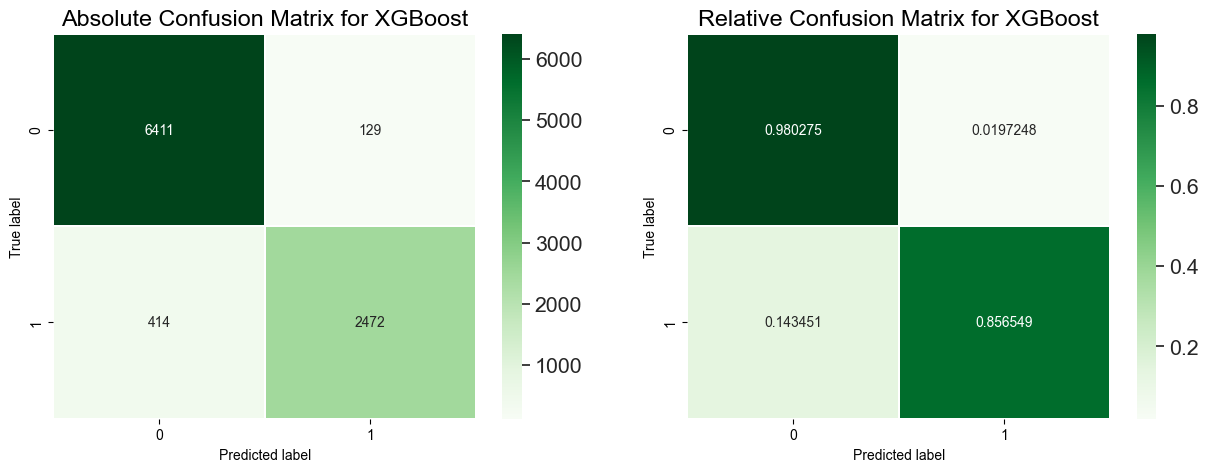

In [24]:
validate_model(best_model_21600, df_validation_21600)